# Classification with Fashion MNIST

##Specifying the TensorFlow version

Running `import tensorflow` will import the default version (currently 1.x). You can use 2.x by running a cell with the `tensorflow_version` magic **before** you run `import tensorflow`.

In [1]:
%tensorflow_version 2.x

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
print(tf.__version__)

2.3.0


In [5]:
#Download the Dataset

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Label: 5


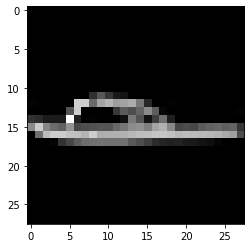

In [7]:
#Visualise the data

%matplotlib inline
import random

i = random.randint(0,100)

print("Label: %s" % train_labels[i])
plt.imshow(train_images[i], cmap = 'gray')

Each training and test example is assigned one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

## Step 3: Understand the data format

We are given the images as a 3-D array of integer values that is of shape (N, 28, 28), where N is the number of images in the training or test set. The labels are 1-D array of the integer values of each image.

In [8]:
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


## Step 4: Reformat the images
Here, we'll flatten (or unstack) the images. There are deep learning techniques that work with 2d images directly (rather than their flattened representation), but we'll start with this format. Instead of working with a 28 by 28 image, we'll unstack it into a 28 * 28 = 784 length array.

- We want to convert the 3-D array of shape (N, 28, 28) to a 2-D array of shape (N, 784) where the second dimension is just an array of all the pixels in an image. This is called flattening, or unstacking, the images.
- We also want to convert the pixel values from a number between 0 and 255 to a number between 0 and 1.

In [10]:
TRAINING_SIZE = len(train_images)
TEST_SIZE = len(test_images)

#Reshape from (N,28,28) to (N,28*28=784)
train_images = np.reshape(train_images, (TRAINING_SIZE, 784))
test_images = np.reshape(test_images, (TEST_SIZE, 784))

#Convert the arrays to float as compared to uint8
train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

# Convert the pixel values from integers between 0 and 255 to floats between 0 and 1
train_images /= 255
test_images /=  255

## Step 5: Reformat the labels
Next, we want to convert the labels from an integer format (e.g., "2" or "Pullover"), to a one hot encoding (e.g., "0, 0, 1, 0, 0, 0, 0, 0, 0, 0"). To do so, we'll use the **tf.keras.utils.to_categorical** function.

In [11]:
NUM_CAT = 10

print("Before", train_labels[0]) # The format of the labels before conversion

train_labels  = tf.keras.utils.to_categorical(train_labels, NUM_CAT)

print("After", train_labels[0]) # The format of the labels after conversion

test_labels = tf.keras.utils.to_categorical(test_labels, NUM_CAT)

Before 9
After [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## Step 6: Build the model

In [12]:
# Cast the labels to floats, needed later
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)

In [13]:
#Create a Sequential model

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape = (784,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(NUM_CAT, activation=tf.nn.softmax))


#Create a Keras version Optimiser

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#Compile and print the summary of model

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics =['accuracy'])

# Model summary can be created by calling the summary() function on the model that returns a string that in turn can be printed.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Keras provides a way to summarize a model.

The summary is textual and includes information about:

* The layers and their order in the model.
* The output shape of each layer.
* The number of parameters (weights) in each layer.
* The total number of parameters (weights) in the model.

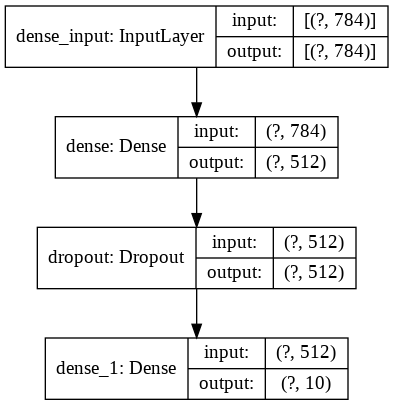

In [14]:
#Plot model summary

tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

The plot_model() function in Keras will create a plot of your network. This function takes a few useful arguments:

* model: (required) The model that you wish to plot.
* to_file: (required) The name of the file to which to save the plot.
* show_shapes: (optional, defaults to False) Whether or not to show the output shapes of each layer.
* show_layer_names: (optional, defaults to True) Whether or not to show the name for each layer.

## Step 7: Save model in a model file
Save your model by calling the save() function on the model and specifying the filename. We can do this by saving it to the file model.h5.

In [15]:
# Model Checkpoint
# HDF5 file format is built for fast I/O processing and storage.
# HDF5 is a self-describing file format, all data and metadata can be passed along in one file.

filepath="weights.fashion_mnist.best.hdf5"

## Step 8: Keras callbacks
* A callback is a set of functions to be applied at given stages of the training procedure. 
* We use a callback when we want to automate some tasks after every training/epochs. This includes: 

  * Stopping training when you reach a certain accuracy/loss score, or 
  * Saving model as a checkpoint after each successful epoch.

### ModelCheckpoint

This callback saves the model after every epoch. Here are some relevant metrics:

* filepath: the file path you want to save your model in
* monitor: the value being monitored
* save_best_only: set this to True if you do not want to overwrite the latest best model
* mode: auto, min, or max. For example, you set mode=’min’ if the monitored value is val_loss and you want to minimize it.

In [16]:
#Model checkpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

###EarlyStopping

This callback avoids overfitting by terminating the process early. The EarlyStoppingfunction has various metrics/arguments that you can modify to set up when the training process should stop. Here are some relevant metrics:

* monitor: value being monitored, i.e: val_loss
* min_delta: minimum change in the monitored value. For example, min_delta=1 means that the training process will be stopped if the absolute change of the monitored value is less than 1
* patience: number of epochs with no improvement after which training will be stopped
* restore_best_weights: set this metric to True if you want to keep the best weights once stopped

In [17]:
#Early stopping checkpoint
early_stopping_checkpoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

### Visualizing model with Tensorboard

**TensorBoard is a visualization tool provided with TensorFlow**

This callback logs events for TensorBoard, including: 
* Metrics summary plots 
* Training graph visualization 

In [18]:
!ls

model_plot.png	sample_data


In [19]:
!rm -rf tf-log/

In [20]:
"""
Tensorboard log
"""
# Create a folder
log_dir = './tf-log/fmnist2'
# Mention include all explanation behind callbacks
os.makedirs(log_dir,exist_ok=True)
# Define tensorboard callback
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir,profile_batch=0)

In [21]:
?tf.keras.callbacks.TensorBoard

In [22]:
# Load tensorboard in colab
%load_ext tensorboard
%tensorboard --logdir {log_dir}

<IPython.core.display.Javascript object>

## Step 9: Train the model 

In [23]:
batch_size = 32

fitted_model = model.fit(
        train_images, train_labels,
        epochs=30,
        validation_data=(test_images, test_labels),
        batch_size = 32,
        callbacks=[tb_cb,checkpoint,early_stopping_checkpoint]
        
        )

Epoch 1/30
1870/1875 [============================>.] - ETA: 0s - loss: 0.9032 - accuracy: 0.7019
Epoch 00001: val_accuracy improved from -inf to 0.77090, saving model to weights.fashion_mnist.best.hdf5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.9024 - accuracy: 0.7021 - val_loss: 0.6272 - val_accuracy: 0.7709
Epoch 2/30
1864/1875 [============================>.] - ETA: 0s - loss: 0.5728 - accuracy: 0.7932
Epoch 00002: val_accuracy improved from 0.77090 to 0.80190, saving model to weights.fashion_mnist.best.hdf5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5726 - accuracy: 0.7933 - val_loss: 0.5440 - val_accuracy: 0.8019
Epoch 3/30
1871/1875 [============================>.] - ETA: 0s - loss: 0.5064 - accuracy: 0.8192
Epoch 00003: val_accuracy improved from 0.80190 to 0.81670, saving model to weights.fashion_mnist.best.hdf5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5062 - accuracy: 0.8193 - val_loss: 0.5036 - val_acc

## External Tensorboard visualization

In [24]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [25]:
# start tensorboard on localhost 6006

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [26]:
# start ngrok and asking ngrok to forward to port to 6006 where tensorboard is running 
get_ipython().system_raw('./ngrok http 6006 &')

In [27]:
# get url generated from ngrok

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://019974154c73.ngrok.io


## Step 10: Model Prediction

In [28]:
labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
def predict_image(model,img):
  
  classifier=model
  plt.imshow(img.reshape(28,28), cmap='gray')
  x=img.reshape(1,784) 
  result = classifier.predict(x)
  print(np.argmax(result))
  print(labels[np.argmax(result)])

8
Bag


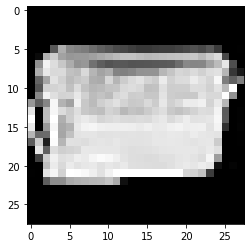

In [29]:
predict_image(model,test_images[56])

In [30]:
test_labels[56]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)